In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import Normalize
import matplotlib.cm as cm
from scipy.stats import gaussian_kde
from IPython.display import HTML
from tqdm import tqdm
from matplotlib.colors import LogNorm
from matplotlib import gridspec
%matplotlib inline
# plt.rcParams.update({
#     'axes.labelcolor': 'white',     # Axis labels
#     'xtick.color': 'white',         # X-axis tick labels
#     'ytick.color': 'white',         # Y-axis tick labels
#     'axes.titlecolor': 'white',     # Title color
#     'legend.facecolor': 'black',    # Legend background
#     'legend.edgecolor': 'white',    # Legend border
#     'legend.fontsize': 'medium',    # Legend font size
#     'text.color': 'white',          # General text color
#     'figure.facecolor': 'black',    # Figure background
#     'figure.edgecolor': 'white',    # Figure edge color
#     'axes.facecolor': 'black',      # Axes background
#     'axes.edgecolor': 'white'       # Axes edge (border) color
# })

In [97]:
path = '/home/pablo/gadget4/examples/G2-galaxy/output/'
save_path = '/home/pablo/Desktop/master/simulacion_numericas/'

# Leer datos del archivo HDF5
with h5py.File(path + "snapshot_006.hdf5", "r") as f:
    pos = np.asarray(f["/PartType2/Coordinates"])

# Extraer coordenadas X, Y, Z
x_first, y_first, z_first = pos[:, 0], pos[:, 1], pos[:, 2]

#Lista de colores, se asignan en función de la coordenada X (solo)
colors = []

# Asignar colores en función de la coordenada X (primer frame)
colors_first = np.where((x_first < 20), 'b', 'r')  # azul si x < 0, rojo si no
colors.append(colors_first)


n_frames = 501

# Lista de snapshots
snapshots = [f"snapshot_{ii:03d}.hdf5" for ii in range(1, n_frames)] # snapshot_001, ..., snapshot_n

# Leer datos de cada snapshot
data = []
for snap in snapshots:
    with h5py.File(path +  snap, "r") as f:
        pos = np.asarray(f["/PartType2/Coordinates"])
        data.append(pos)



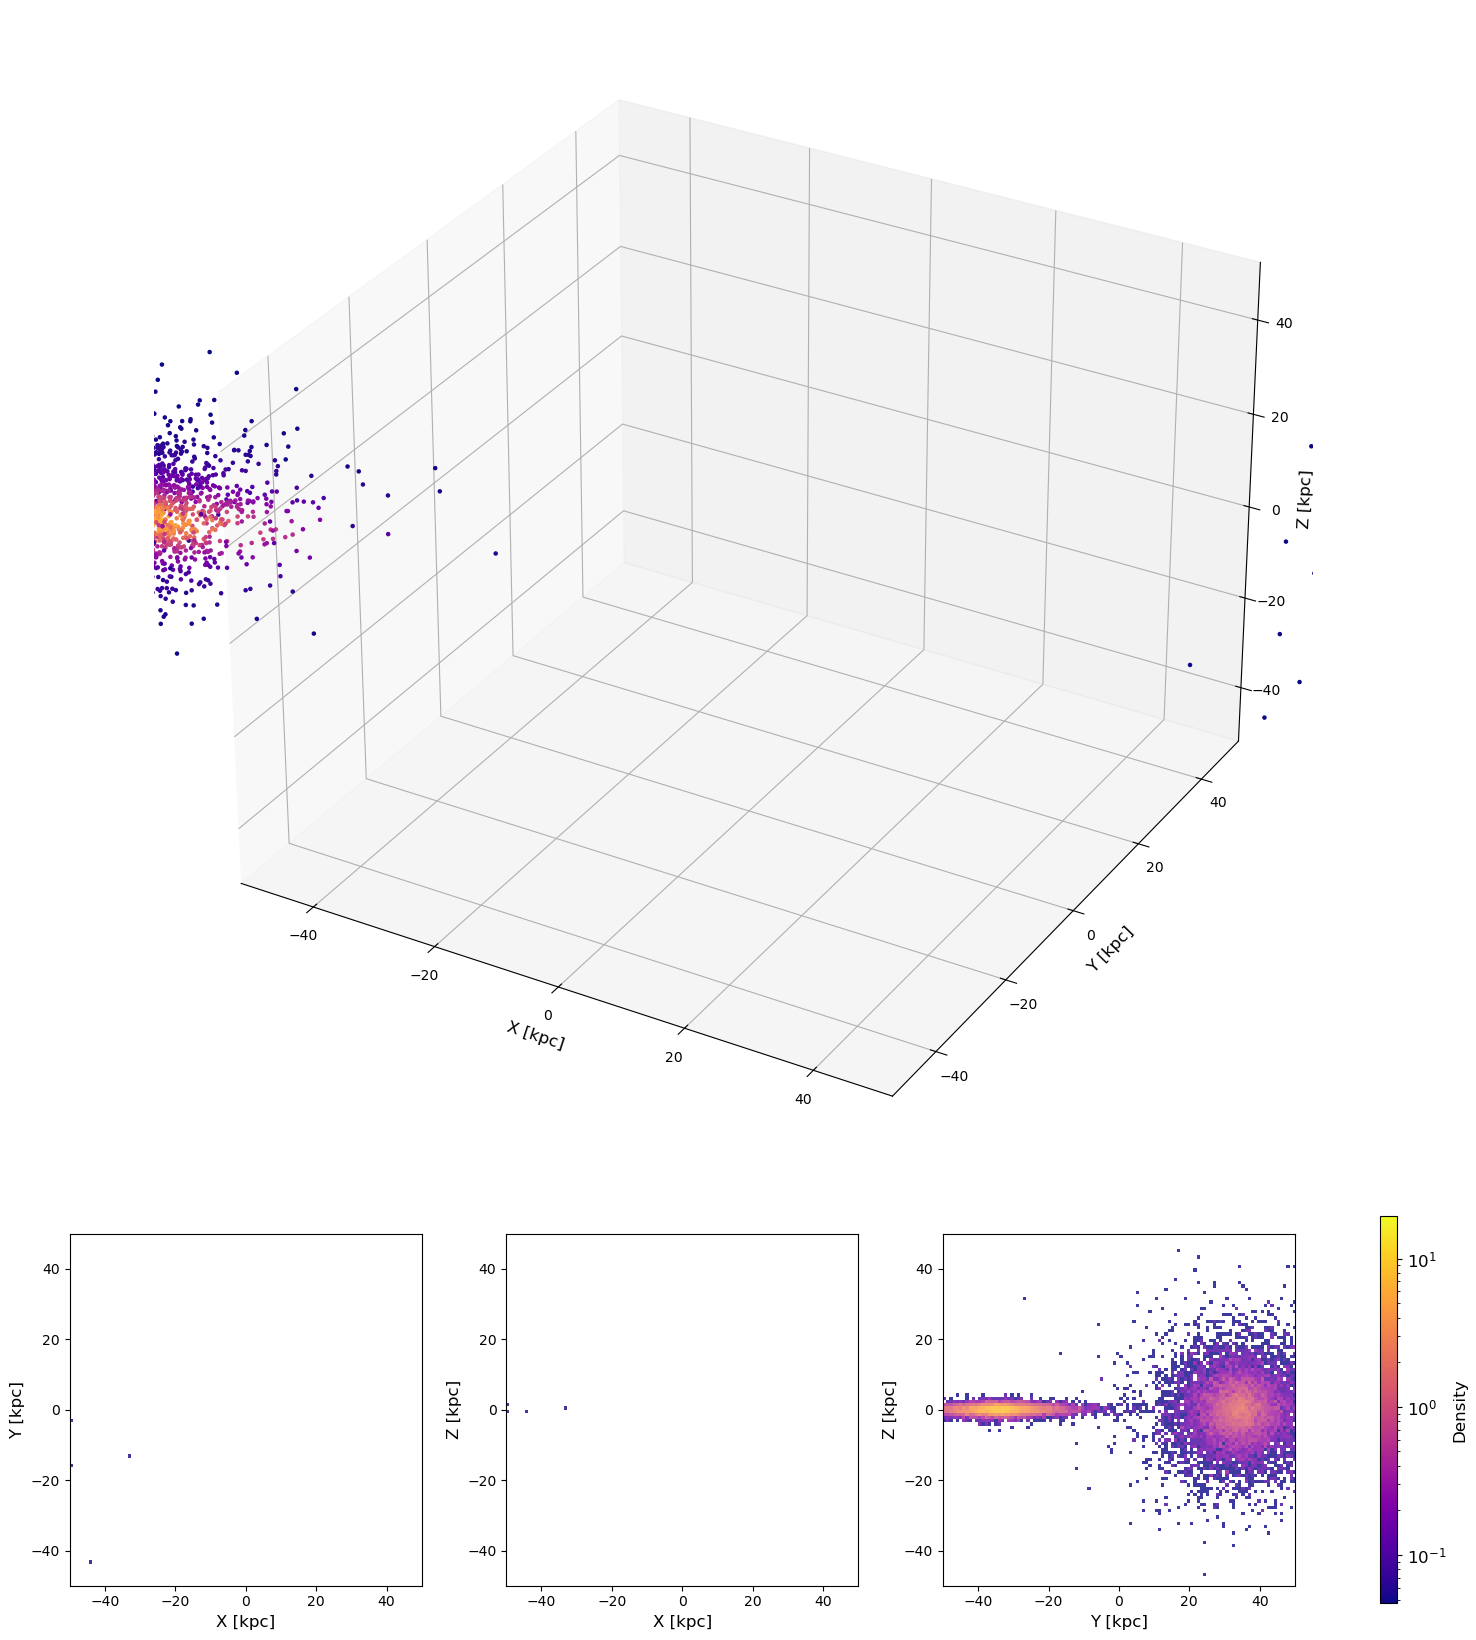

In [ ]:
mass_per_point = 0.00023252 * 10**10  # Masa de cada punto en unidades de M_sun

# Grid setup
grid_size = 110
x_bins = np.linspace(-50, 50, grid_size+1)
y_bins = np.linspace(-50, 50, grid_size+1)

# Compute global normalization values
min_density, max_density = np.inf, -np.inf
for frame in range(len(data)):
    x, y, z = data[frame][:, 0], data[frame][:, 1], data[frame][:, 2]
    density, _, _ = np.histogram2d(x, y, bins=(x_bins, y_bins))
    density_mass = density * mass_per_point
    min_density = min(min_density, np.min(density_mass[density_mass > 0]))
    max_density = max(max_density, np.max(density_mass))

# Log normalization
norm = LogNorm(vmin=min_density, vmax=max_density)

# Initialize figure with GridSpec layout
fig = plt.figure(figsize=(15, 17))
gs = gridspec.GridSpec(2, 4, height_ratios=[3, 1], width_ratios=[1, 1, 1, 0.05])

# Create subplots
ax_3d = fig.add_subplot(gs[0, :], projection='3d')  # 3D plot
axes_2d = [fig.add_subplot(gs[1, i]) for i in range(3)]  # 1x3 subplots
cax = fig.add_subplot(gs[1, 3])  # Colorbar axis

# Labels for 2D subplots
labels = [('X [kpc]', 'Y [kpc]'), ('X [kpc]', 'Z [kpc]'), ('Y [kpc]', 'Z [kpc]')]

# Function to compute density
def compute_density(x, y, z):
    xyz = np.vstack([x, y, z])
    kde = gaussian_kde(xyz)(xyz)
    return kde / np.max(kde)  # Normalize 0 to 1

# Animation update function
def update(frame):
    ax_3d.clear()
    ax_3d.set_xlim([-50, 50])
    ax_3d.set_ylim([-50, 50])
    ax_3d.set_zlim([-50, 50])
    ax_3d.set_xlabel("X [kpc]", fontsize=12)
    ax_3d.set_ylabel("Y [kpc]", fontsize=12)
    ax_3d.set_zlabel("Z [kpc]", fontsize=12)
    # ax_3d.set_title(f"Frame {frame+1}")

    x, y, z = data[frame][:, 0], data[frame][:, 1], data[frame][:, 2]
    density = compute_density(x, y, z)
    colors = cm.plasma(density)

    ax_3d.scatter(x, y, z, c=colors, s=5, alpha=1)

    # Update 2D density plots
    projections = [(x, y), (x, z), (y, z)]
    for ax, (label_x, label_y), (x_proj, y_proj) in zip(axes_2d, labels, projections):
        ax.clear()
        ax.set_xlim([-50, 50])
        ax.set_ylim([-50, 50])
        ax.set_xlabel(label_x, fontsize=12)
        ax.set_ylabel(label_y, fontsize=12)

        density_2d, _, _ = np.histogram2d(x_proj, y_proj, bins=(x_bins, y_bins))
        density_mass_2d = density_2d * mass_per_point
        ax.imshow(density_mass_2d.T, origin='lower', extent=[-50, 50, -50, 50], cmap='plasma', norm=norm, alpha=0.8)

    return ax_3d, *axes_2d

# ax_3d.xaxis.pane.set_facecolor((0.1, 0.1, 0.1, 0.8))
# ax_3d.yaxis.pane.set_facecolor((0.1, 0.1, 0.1, 0.8))
# ax_3d.zaxis.pane.set_facecolor((0.1, 0.1, 0.1, 0.8))

# Create animation
ani = animation.FuncAnimation(fig, update, frames=len(data), interval=150, repeat=True)

# Shared colorbar
im = axes_2d[0].imshow(np.zeros((200, 200)), cmap='plasma', norm=norm)
cbar = fig.colorbar(im, cax=cax, orientation='vertical', label='Density')
cbar.ax.tick_params(labelsize=12)
cbar.set_label('Density', fontsize=12)

plt.tight_layout(pad=3)

# Save animation
ani.save(save_path + "animation_galaxy_merge_3d_planes_density.gif", writer="pillow", fps=25)


$$\textbf{Collapse Spehere}$$

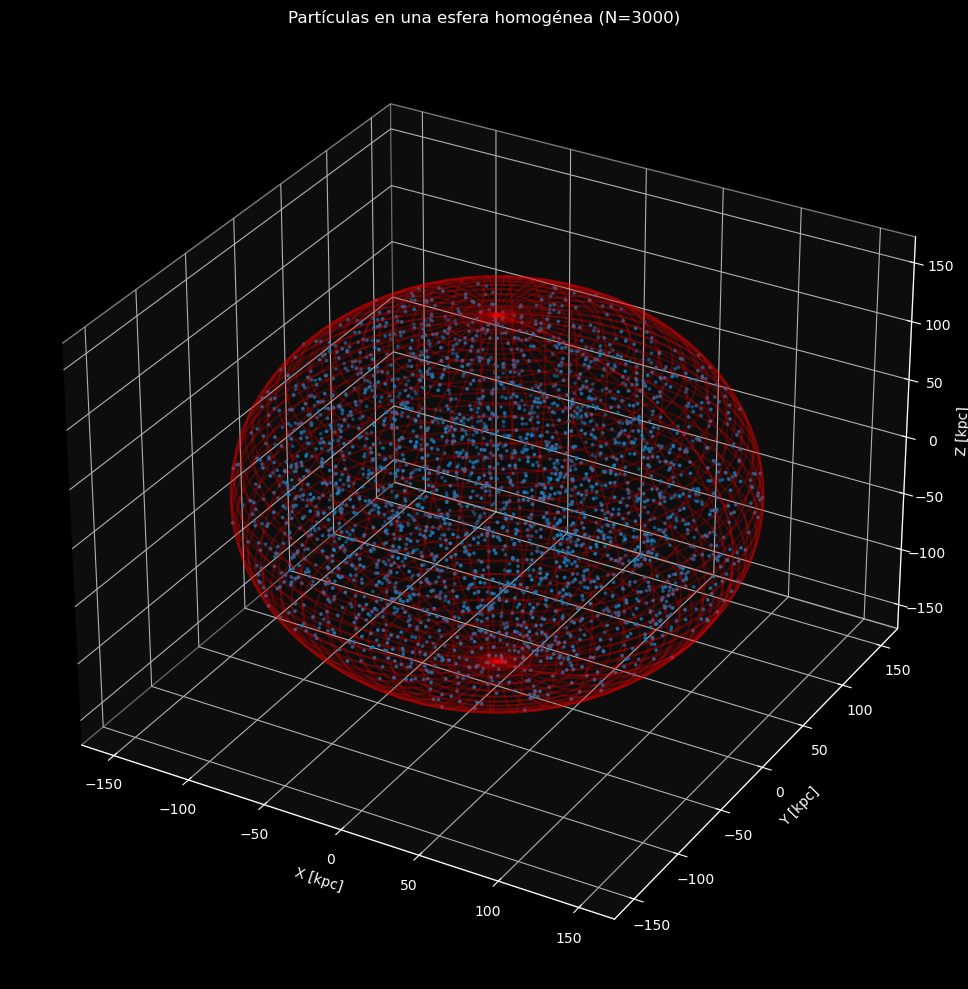

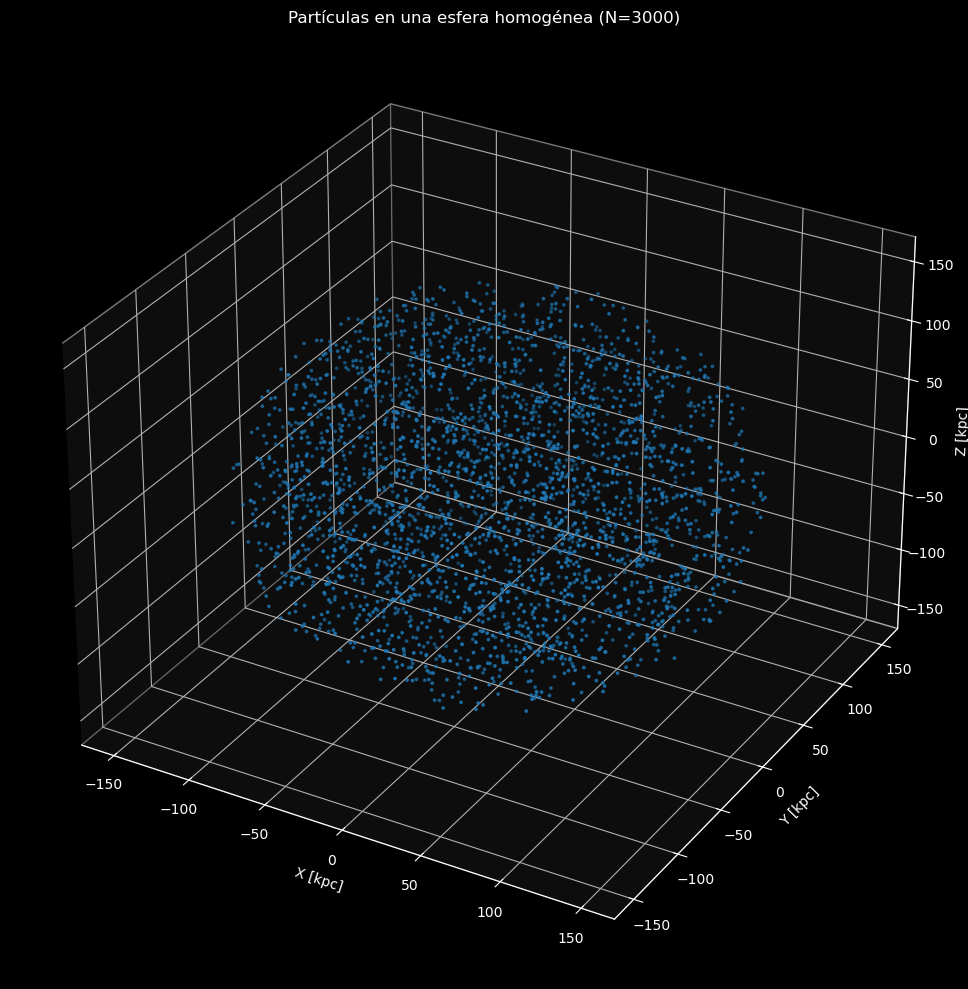

In [ ]:
def generar_esfera(N, R):
    # Generar radios con distribución uniforme en volumen
    r = R * np.cbrt(np.random.uniform(0, 1, N))
    
    # Generar ángulos uniformemente distribuidos
    theta = np.arccos(1 - 2 * np.random.uniform(0, 1, N))  # Distribución uniforme en cos(theta)
    phi = np.random.uniform(0, 2 * np.pi, N)  # Distribución uniforme en [0, 2pi]
    
    # Convertir a coordenadas cartesianas
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    
    # Inicializar velocidades en cero
    vx, vy, vz = np.zeros(N), np.zeros(N), np.zeros(N)
    ind = np.arange(1, N + 1)
    
    return x, y, z, vx, vy, vz, ind

def guardar_datos(nombre_archivo, x, y, z):
    datos = np.column_stack((x, y, z))
    np.savetxt(nombre_archivo, datos, delimiter=",", header="x,y,z", comments="")

def cargar_datos(nombre_archivo):
    return np.loadtxt(nombre_archivo, delimiter=",", skiprows=1).T

def set_axes_equal(ax):
    extents = np.array([getattr(ax, f'get_{dim}lim')() for dim in 'xyz'])
    centers = np.mean(extents, axis=1)
    max_size = max(extents[:, 1] - extents[:, 0]) / 2
    for center, dim in zip(centers, 'xyz'):
        getattr(ax, f'set_{dim}lim')(center - max_size, center + max_size)


# Parámetros
N = 3000
R = 150.
archivo_datos = "./data/sphere_particle_coordinates.csv"

# Generar y guardar la esfera
x, y, z, vx, vy, vz, ind = generar_esfera(N, R)
guardar_datos(archivo_datos, x, y, z)
%matplotlib inline
# Cargar y graficar la esfera
datos_x, datos_y, datos_z = cargar_datos(archivo_datos)
# graficar_esfera(datos_x, datos_y, datos_z, R)  # Con esfera de referencia
# graficar_esfera(datos_x, datos_y, datos_z, R, plot_sphere=False)  # Solo partículas

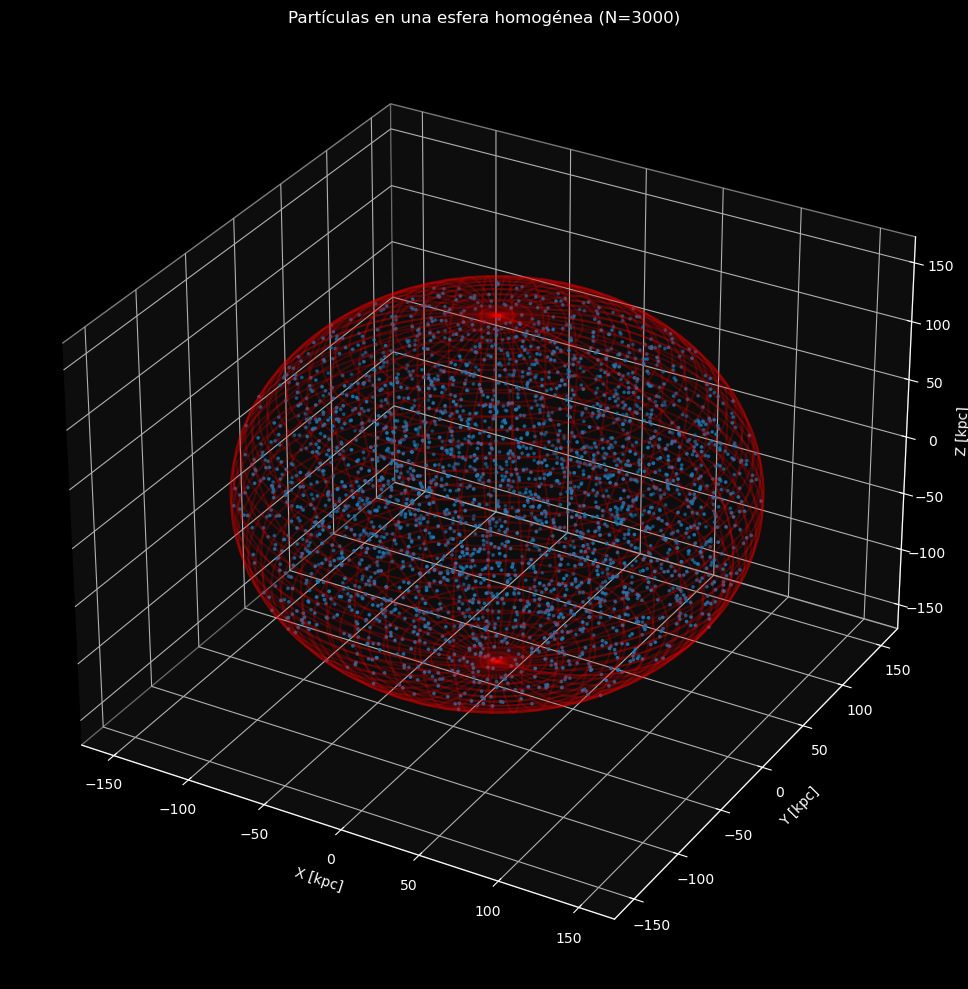

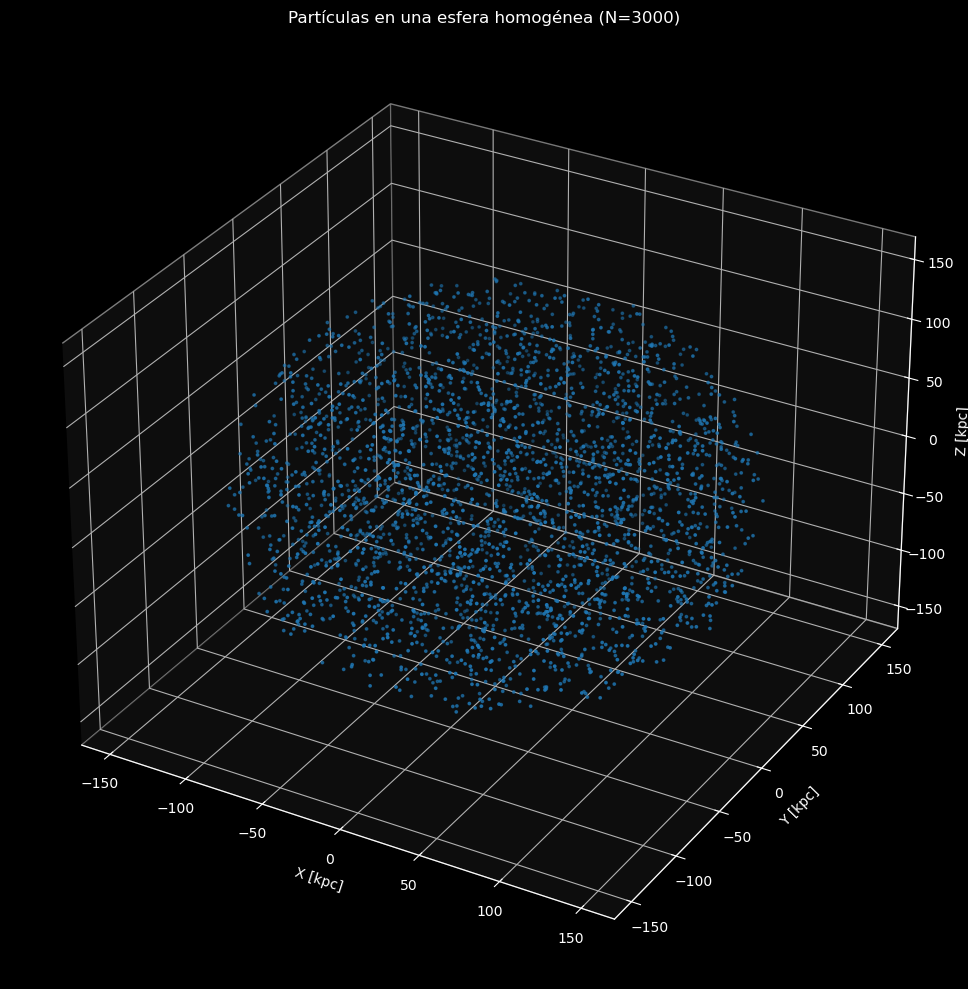

In [8]:
def generar_esfera(N, R):
    # Volúmenes
    Vc = (2 * R) ** 3  # Volumen del cubo
    Vs = (4/3) * np.pi * R ** 3  # Volumen de la esfera
    
    # Número de partículas en el cubo
    Nc = int(N * (Vc / Vs))
    
    # Generar Nc puntos en el cubo [-R, R] en cada coordenada
    x, y, z = np.random.uniform(-R, R, (3, Nc))
    # x, y, z = np.random.normal(0, 150, (3, Nc))
    
    # Aplicar la máscara para restringir a la esfera
    mask = x**2 + y**2 + z**2 < R**2
    x_sphere, y_sphere, z_sphere = x[mask], y[mask], z[mask]

    vx, vy, vz = np.zeros([len(x_sphere)]), np.zeros([len(y_sphere)]), np.zeros([len(z_sphere)])

    ind = np.arange(1, len(x_sphere) + 1)
    
    return x_sphere, y_sphere, z_sphere, vx, vy, vz, ind

def guardar_datos(nombre_archivo, x, y, z):
    datos = np.column_stack((x, y, z))
    np.savetxt(nombre_archivo, datos, delimiter=",", header="x,y,z", comments="")

def cargar_datos(nombre_archivo):
    return np.loadtxt(nombre_archivo, delimiter=",", skiprows=1).T

def set_axes_equal(ax):
    """Configura los ejes para que tengan la misma escala."""
    extents = np.array([getattr(ax, f'get_{dim}lim')() for dim in 'xyz'])
    centers = np.mean(extents, axis=1)
    max_size = max(extents[:, 1] - extents[:, 0]) / 2
    for center, dim in zip(centers, 'xyz'):
        getattr(ax, f'set_{dim}lim')(center - max_size, center + max_size)

def graficar_esfera(x, y, z, R, plot_sphere=True):
    num_particulas = len(x)  # Contar el número de partículas
    
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x, y, z, s=3)  # Aumentar tamaño de partículas
    
    if plot_sphere:
        # Dibujar esfera de referencia
        u = np.linspace(0, 2 * np.pi, 100)
        v = np.linspace(0, np.pi, 50)
        xs = R * np.outer(np.cos(u), np.sin(v))
        ys = R * np.outer(np.sin(u), np.sin(v))
        zs = R * np.outer(np.ones(np.size(u)), np.cos(v))
        ax.plot_wireframe(xs, ys, zs, color='r', alpha=0.2)
    
    set_axes_equal(ax)  # Ajustar los ejes para que sean iguales
    
    ax.set_xlabel("X [kpc]")
    ax.set_ylabel("Y [kpc]")
    ax.set_zlabel("Z [kpc]")
    ax.set_title(f"Partículas en una esfera homogénea (N={num_particulas})")

    ax.xaxis.pane.set_facecolor((0.1, 0.1, 0.1, 0.8))
    ax.yaxis.pane.set_facecolor((0.1, 0.1, 0.1, 0.8))
    ax.zaxis.pane.set_facecolor((0.1, 0.1, 0.1, 0.8))

    plt.tight_layout()

    plt.show()

# Parámetros
N = 3000  # Número de partículas deseado
R = 150.   # Radio de la esfera
archivo_datos = "./data/sphere_particle_coordinates.csv"

# Generar y guardar la esfera
x, y, z, vx, vy, vz, ind = generar_esfera(N, R)
guardar_datos(archivo_datos, x, y, z)

# %matplotlib inline
# Cargar y graficar la esfera
# datos_x, datos_y, datos_z = cargar_datos(archivo_datos)
graficar_esfera(datos_x, datos_y, datos_z, R)  # Con esfera de referencia
graficar_esfera(datos_x, datos_y, datos_z, R, plot_sphere=False)  # Solo partículas

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def generar_esfera_malla(N, R):
    puntos_por_dimension = int(np.cbrt(N))
    
    lin_space = np.linspace(-R, R, puntos_por_dimension)
    x, y, z = np.meshgrid(lin_space, lin_space, lin_space)
    x, y, z = x.ravel(), y.ravel(), z.ravel()
    
    mask = x**2 + y**2 + z**2 < R**2
    x_sphere, y_sphere, z_sphere = x[mask], y[mask], z[mask]
    
    redshift = 8
    r_magnitudes = np.sqrt(x_sphere**2 + y_sphere**2 + z_sphere**2) + 1e-10
    hubble_z = 70 * 1e-3 * np.sqrt(0.3 * (1 + redshift)**3 + 0.7)

    # vx, vy, vz = hubble_z * x_sphere , hubble_z * y_sphere , hubble_z * z_sphere 
    vx, vy, vz = np.zeros_like(x_sphere), np.zeros_like(x_sphere), np.zeros_like(x_sphere)
    
    ind = np.arange(1, len(x_sphere) + 1)
    
    return x_sphere, y_sphere, z_sphere, vx, vy, vz, ind

def graficar_esfera(x, y, z, R, plot_sphere=True):
    num_particulas = len(x)
    
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x, y, z, s=5, alpha=1)
    
    if plot_sphere:
        u = np.linspace(0, 2 * np.pi, 100)
        v = np.linspace(0, np.pi, 50)
        xs = R * np.outer(np.cos(u), np.sin(v))
        ys = R * np.outer(np.sin(u), np.sin(v))
        zs = R * np.outer(np.ones(np.size(u)), np.cos(v))
        ax.plot_wireframe(xs, ys, zs, color='r', alpha=0.2)
    
    ax.set_xlabel("X [kpc]")
    ax.set_ylabel("Y [kpc]")
    ax.set_zlabel("Z [kpc]")
    # ax.set_title(f"Partículas en una esfera en malla cartesiana (N={num_particulas})")
    
    # ax.xaxis.pane.set_facecolor((0.1, 0.1, 0.1, 0.8))
    # ax.yaxis.pane.set_facecolor((0.1, 0.1, 0.1, 0.8))
    # ax.zaxis.pane.set_facecolor((0.1, 0.1, 0.1, 0.8))

    plt.tight_layout()
    plt.show()
    # fig.savefig('/home/pablo/Desktop/master/simulacion_numericas/parte_1/latex/images/malla.pdf')

def guardar_datos(nombre_archivo, x, y, z, vx, vy, vz):
    datos = np.column_stack((x, y, z, vx, vy, vz))
    np.savetxt(nombre_archivo, datos, delimiter=",", header="x,y,z,vx,vy,vz", comments="")

# Parámetros
N = 5000
R = 150.

# Generar y graficar la esfera con malla cartesiana
x, y, z, vx, vy, vz, ind = generar_esfera_malla(N, R)
# graficar_esfera(x, y, z, R)


archivo_datos = "./data/sphere_particle_coordinates.csv"
guardar_datos(archivo_datos, x, y, z, vx, vy, vz)

In [39]:
#write intial conditions file

IC = h5py.File('/home/pablo/gadget4/examples/G2-gassphere/IC.hdf5', 'w')

## create hdf5 groups
header = IC.create_group("Header")
part1 = IC.create_group("PartType1")


## header entries
NumPart = np.array([ind[-1]])
header.attrs.create("NumPart_ThisFile", np.array([0, ind[-1]]))
header.attrs.create("NumPart_Total", np.array([0, ind[-1]]))
header.attrs.create("MassTable", np.array([0, 100 / ind[-1]]) )
header.attrs.create("Time", 0.0)
header.attrs.create("Redshift", 0.0)
header.attrs.create("BoxSize", 1.0)
header.attrs.create("NumFilesPerSnapshot", 1)
header.attrs.create("HubbleParam", 1.0)

part1.create_dataset("ParticleIDs", data=ind )
part1.create_dataset("Coordinates", data=np.column_stack([x, y, z]))
part1.create_dataset("Velocities", data=np.column_stack([vx, vy, vz]))


IC.close()

In [103]:
path = '/home/pablo/gadget4/examples/G2-gassphere/output/'
save_path = '/home/pablo/Desktop/master/simulacion_numericas/'

# Leer datos del archivo HDF5
with h5py.File(path + "snapshot_006.hdf5", "r") as f:
    pos = np.asarray(f["/PartType1/Coordinates"])

# Extraer coordenadas X, Y, Z
x, y, z = pos[:, 0], pos[:, 1], pos[:, 2]
    
n_frames = 201

# Lista de snapshots
snapshots = [f"snapshot_{ii:03d}.hdf5" for ii in range(1, n_frames)] # snapshot_001, ..., snapshot_n

# Leer datos de cada snapshot
data = []
for snap in snapshots:
    with h5py.File(path +  snap, "r") as f:
        pos = np.asarray(f["/PartType1/Coordinates"])
        data.append(pos)

In [106]:
%matplotlib notebook

# Grid setup
grid_size = 110
x_bins = np.linspace(-50, 50, grid_size + 1)
y_bins = np.linspace(-50, 50, grid_size + 1)

# Compute global normalization values
min_density, max_density = np.inf, -np.inf
for frame in range(len(data)):
    x, y, z = data[frame][:, 0], data[frame][:, 1], data[frame][:, 2]
    density, _, _ = np.histogram2d(x, y, bins=(x_bins, y_bins))
    min_density = min(min_density, np.min(density[density > 0]))
    max_density = max(max_density, np.max(density))

# Log normalization
norm = LogNorm(vmin=min_density, vmax=max_density)

# Initialize figure with GridSpec layout
fig = plt.figure(figsize=(15, 17))
gs = gridspec.GridSpec(2, 4, height_ratios=[3, 1], width_ratios=[1, 1, 1, 0.05])

# Create subplots
ax_3d = fig.add_subplot(gs[0, :], projection='3d')  # 3D plot
axes_2d = [fig.add_subplot(gs[1, i]) for i in range(3)]  # 1x3 subplots
cax = fig.add_subplot(gs[1, 3])  # Colorbar axis

# Labels for 2D subplots
labels = [('X [kpc]', 'Y [kpc]'), ('X [kpc]', 'Z [kpc]'), ('Y [kpc]', 'Z [kpc]')]

# Function to compute density
def compute_density(x, y, z):
    xyz = np.vstack([x, y, z])
    kde = gaussian_kde(xyz)(xyz)
    return kde / np.max(kde)  # Normalize 0 to 1

# Animation update function
def update(frame):
    ax_3d.clear()
    ax_3d.set_xlim([-150, 150])
    ax_3d.set_ylim([-150, 150])
    ax_3d.set_zlim([-150, 150])
    ax_3d.set_xlabel("X [kpc]", fontsize=12)
    ax_3d.set_ylabel("Y [kpc]", fontsize=12)
    ax_3d.set_zlabel("Z [kpc]", fontsize=12)

    ax_3d.xaxis.pane.set_facecolor((0.1, 0.1, 0.1, 0.8))
    ax_3d.yaxis.pane.set_facecolor((0.1, 0.1, 0.1, 0.8))
    ax_3d.zaxis.pane.set_facecolor((0.1, 0.1, 0.1, 0.8))

    x, y, z = data[frame][:, 0], data[frame][:, 1], data[frame][:, 2]
    density = compute_density(x, y, z)
    colors = plt.cm.plasma(density)
    
    ax_3d.scatter(x, y, z, s=10, alpha=0.9, c=colors)
    
    # Update 2D density plots
    projections = [(x, y), (x, z), (y, z)]
    for ax, (label_x, label_y), (x_proj, y_proj) in zip(axes_2d, labels, projections):
        ax.clear()
        ax.set_xlim([-50, 50])
        ax.set_ylim([-50, 50])
        ax.set_xlabel(label_x, fontsize=12)
        ax.set_ylabel(label_y, fontsize=12)
        
        density_2d, _, _ = np.histogram2d(x_proj, y_proj, bins=(x_bins, y_bins))
        ax.imshow(density_2d.T, origin='lower', extent=[-50, 50, -50, 50], cmap='plasma', norm=norm, alpha=0.8)
    
    return ax_3d, *axes_2d

# Create animation  
ani = animation.FuncAnimation(fig, update, frames=len(data), interval=150, repeat=True)

# Shared colorbar
im = axes_2d[0].imshow(np.zeros((200, 200)), cmap='plasma', norm=norm)
cbar = fig.colorbar(im, cax=cax, orientation='vertical', label='Density')
cbar.ax.tick_params(labelsize=12)
cbar.set_label('Density', fontsize=12)

plt.tight_layout(pad=3)

# Save as GIF
save_path = "animation_collapse_planes_density.gif"
writer = animation.PillowWriter(fps=30)

with tqdm(total=len(data), desc="Generating GIF", unit="frame") as pbar:
    def update_progress(frame, *args):
        pbar.update(1)
    ani.save(save_path, writer=writer, progress_callback=update_progress)

<IPython.core.display.Javascript object>

Generating GIF: 100%|██████████| 200/200 [00:53<00:00,  3.72frame/s]


In [44]:
from scipy.stats import binned_statistic
from tqdm import tqdm
%matplotlib notebook

# Parámetros
num_bins = 30  # Número de bins logarítmicos
mass_per_point =  100 / ind[-1]

# Figura y ejes
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("$\log$ r [kpc]")
ax.set_ylabel(r"$\log$ $\rho$ [$M_{\odot}/kpc^3$]")
ax.set_xlim(0.1, 100)
ax.set_ylim(1e-3, 1e3)
ax.grid(True, which="both", linestyle="--", alpha=0.5)
line, = ax.plot([], [], 'o-', lw=2, markersize=4, label="Densidad")
ax.legend()

# Función de actualización

def update(frame):
    ax.clear()
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel("r [kpc]")
    ax.set_ylabel(r"$\rho$ [$M_{\odot}/kpc^3$]")
    ax.set_xlim(0.1, 10)
    ax.set_ylim(1e-4, 1e2)
    ax.grid(True, which="both", linestyle="--", alpha=0.2)
    
    x, y, z = data[frame][:, 0], data[frame][:, 1], data[frame][:, 2]
    r = np.sqrt(x**2 + y**2 + z**2)
    
    bins = np.logspace(np.log10(0.1), np.log10(10), num_bins)
    mass_per_bin, _, _ = binned_statistic(r, np.full_like(r, mass_per_point), statistic="sum", bins=bins)
    volume_bins = (4/3) * np.pi * (bins[1:]**3 - bins[:-1]**3)
    density = mass_per_bin / volume_bins
    
    valid = density > 0
    ax.plot(bins[:-1][valid], density[valid], 'o-', lw=2, color='steelblue', markersize=4, label=f"Frame {frame+1}")
    ax.legend()
    return line,

# Crear animación
ani = animation.FuncAnimation(fig, update, frames=len(data), interval=300, repeat=True)

# # Guardar como GIF
save_path = "test.gif"
writer = animation.PillowWriter(fps=20)

with tqdm(total=len(data), desc="Generando GIF", unit="frame") as pbar:
    def update_progress(frame, *args):
        pbar.update(1)
    ani.save(save_path, writer=writer, progress_callback=update_progress)

<IPython.core.display.Javascript object>

Generando GIF: 100%|██████████| 500/500 [00:52<00:00,  9.51frame/s]


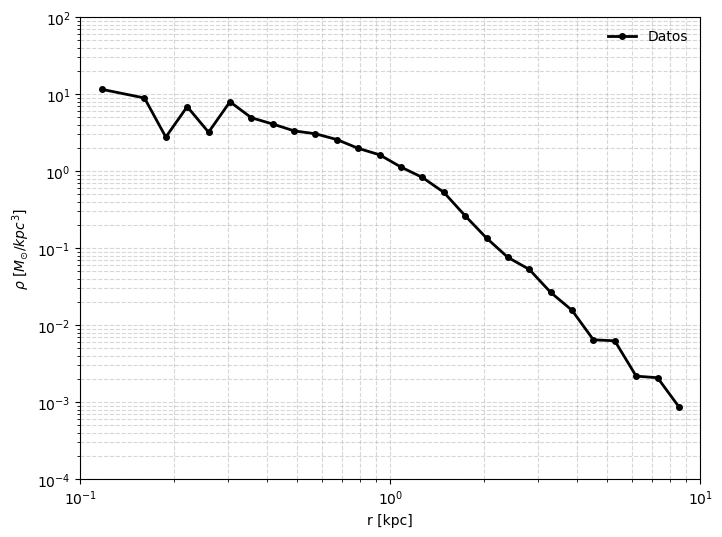

In [50]:
from scipy.stats import binned_statistic
%matplotlib inline 

# Parámetros
num_bins = 30  # Número de bins logarítmicos

# Último frame
data_last = data[-1]  # Asumiendo que 'data' está definido
x, y, z = data_last[:, 0], data_last[:, 1], data_last[:, 2]
r = np.sqrt(x**2 + y**2 + z**2)

# Calcular densidad
bins = np.logspace(np.log10(0.1), np.log10(10), num_bins)
mass_per_bin, _, _ = binned_statistic(r, np.full_like(r, mass_per_point), statistic="sum", bins=bins)
volume_bins = (4/3) * np.pi * (bins[1:]**3 - bins[:-1]**3)
density = mass_per_bin / volume_bins

# Filtrar valores válidos
valid = density > 0

# Crear figura
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("r [kpc]")
ax.set_ylabel(r"$\rho$ [$M_{\odot}/kpc^3$]")
ax.set_xlim(0.1, 10)
ax.set_ylim(1e-4, 1e2)
ax.grid(True, which="both", linestyle="--", alpha=0.5)
ax.plot(bins[:-1][valid], density[valid], 'o-', lw=2, color='k', markersize=4, label="Datos")
ax.legend(frameon=False)

# Mostrar figura
plt.show()

100%|██████████| 500000/500000 [07:23<00:00, 1126.94it/s]


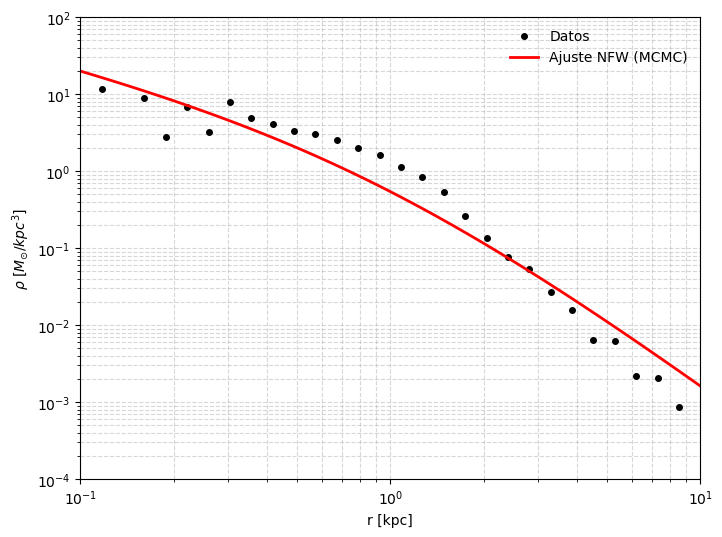

Parámetros ajustados: rho_0 = 2.80e+00, r_s = 0.88 kpc


In [96]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic
import emcee
import corner

# Parámetros
num_bins = 30

# Último frame
data_last = data[-1]
x, y, z = data_last[:, 0], data_last[:, 1], data_last[:, 2]
r = np.sqrt(x**2 + y**2 + z**2)

# Calcular densidad
bins = np.logspace(np.log10(0.1), np.log10(10), num_bins)
mass_per_bin, _, _ = binned_statistic(r, np.full_like(r, mass_per_point), statistic="sum", bins=bins)
volume_bins = (4/3) * np.pi * (bins[1:]**3 - bins[:-1]**3)
density = mass_per_bin / volume_bins

# Filtrar valores válidos
valid = density > 0
r_bins = bins[:-1][valid]
density_valid = density[valid]

# Definir el perfil NFW
def nfw_profile(r, rho_0, r_s):
    return rho_0 / ((r / r_s) * (1 + r / r_s) ** 2)

# Función de log-verosimilitud
def log_likelihood(params, r, density_obs):
    rho_0, r_s = params
    model = nfw_profile(r, rho_0, r_s)
    return -0.5 * np.sum((density_obs - model) ** 2 / model + np.log(model))

# Función de log-prior
def log_prior(params):
    rho_0, r_s = params
    if 0 < rho_0 < 1e8 and 0 < r_s < 100:
        return 0.0  # Prior uniforme
    return -np.inf  # Prior imposible

# Función de log-probabilidad total
def log_probability(params, r, density_obs):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, r, density_obs)

# Configurar MCMC
nwalkers = 100
ndim = 2
initial_guess = [1e6, 1]
pos = initial_guess + 1e5 * np.random.randn(nwalkers, ndim)

# Ejecutar MCMC
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(r_bins, density_valid))
sampler.run_mcmc(pos, 500000, progress=True)

# Obtener valores óptimos
samples = sampler.get_chain(discard=100, thin=10, flat=True)
rho_0_fit, r_s_fit = np.median(samples, axis=0)

# Generar curva ajustada
r_fit = np.logspace(np.log10(0.1), np.log10(10), 100)
density_fit = nfw_profile(r_fit, rho_0_fit, r_s_fit)

# Crear figura
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("r [kpc]")
ax.set_ylabel(r"$\rho$ [$M_{\odot}/kpc^3$]")
ax.set_xlim(0.1, 10)
ax.set_ylim(1e-4, 1e2)
ax.grid(True, which="both", linestyle="--", alpha=0.5)
ax.plot(r_bins, density_valid, 'o', label="Datos", color='k', markersize=4)
ax.plot(r_fit, density_fit, '-', label="Ajuste NFW (MCMC)", color='r', lw=2)
ax.legend(frameon=False)

# Mostrar figura
plt.show()

fig.savefig('/home/pablo/Desktop/master/simulacion_numericas/parte_1/latex/images/perfil_densidad.pdf')

# Parámetros ajustados
print(f"Parámetros ajustados: rho_0 = {rho_0_fit:.2e}, r_s = {r_s_fit:.2f} kpc")


Tiempo de máxima compresión (simulado): 1.05469 Gyr
2K + V =  47426.55999999994


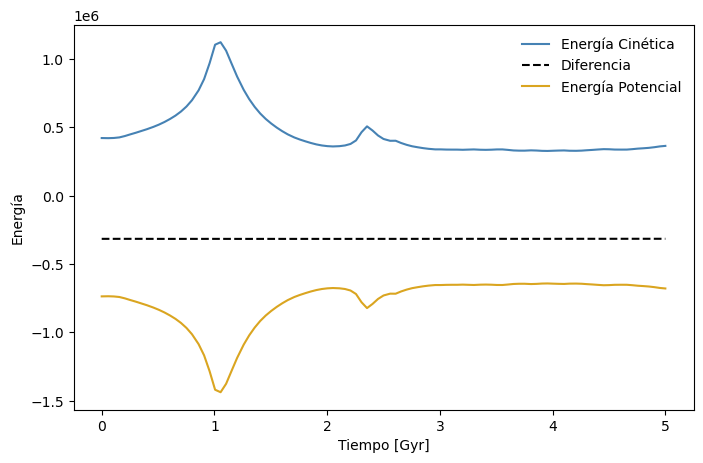

In [101]:
%matplotlib inline

data_energy = np.loadtxt(path + "energy.txt")

# Extraer columnas: tiempo, energía potencial y cinética
time = data_energy[:, 0]
potential_energy = data_energy[:, 2]
kinetic_energy = data_energy[:, 3]


# Encontrar el tiempo de máxima compresión (donde la energía cinética es máxima)
index_max_cin = np.argmax(kinetic_energy)  # Índice del máximo
t_max_compression = time[index_max_cin]
print(f"Tiempo de máxima compresión (simulado): {t_max_compression:.5f} Gyr")

# Últimos valores
last_time = time[-1]
last_potential_energy = potential_energy[-1]
last_kinetic_energy = kinetic_energy[-1]

# Calcular la diferencia
energy_dif = last_potential_energy - last_kinetic_energy

# Comprobar teorema del Virial:
virial_check =  2*last_kinetic_energy + last_potential_energy
print('2K + V = ', virial_check)

# Crear la gráfica
fig = plt.figure(figsize=(8, 5))
plt.plot(time, kinetic_energy, label="Energía Cinética", color="steelblue")
plt.plot(time, kinetic_energy + potential_energy, ls='--', color='k', label='Diferencia')
plt.plot(time, potential_energy, label="Energía Potencial", color="goldenrod")

plt.xlabel("Tiempo [Gyr]")
plt.ylabel("Energía")
plt.legend(frameon=False)
# plt.grid()
plt.show()
fig.savefig('/home/pablo/Desktop/master/simulacion_numericas/parte_1/latex/images/esfera_energia.pdf')

In [ ]:
path = '/home/pablo/gadget4/examples/G2-cluster/output/'
save_path = '/home/pablo/Desktop/master/simulacion_numericas/'

n_frames = 170

# Lista de snapshots
snapshots = [f"snapshot_{ii:03d}.hdf5" for ii in range(0, n_frames + 1)] # snapshot_001, ..., snapshot_n

# Leer datos de cada snapshot
data = []
for snap in snapshots:
    with h5py.File(path +  snap, "r") as f:
        pos = np.asarray(f["/PartType1/Coordinates"])
        data.append(pos)

In [4]:
%matplotlib notebook

lim_inf, lim_sum = -10000, 10000

# Grid setup
grid_size = 110
x_bins = np.linspace(lim_inf, lim_sum, grid_size + 1)
y_bins = np.linspace(lim_inf, lim_sum, grid_size + 1)

# Compute global normalization values
min_density, max_density = np.inf, -np.inf
for frame in range(len(data)):
    x, y, z = data[frame][:, 0], data[frame][:, 1], data[frame][:, 2]
    density, _, _ = np.histogram2d(x, y, bins=(x_bins, y_bins))
    min_density = min(min_density, np.min(density[density > 0]))
    max_density = max(max_density, np.max(density))

# Log normalization
norm = LogNorm(vmin=min_density, vmax=max_density)

# Initialize figure with GridSpec layout
fig = plt.figure(figsize=(16, 17))
# Ajustar width_ratios para dejar espacio a la izquierda
gs = gridspec.GridSpec(2, 5, height_ratios=[3, 1], width_ratios=[-0.1, 1, 1, 1, 0.05])

# Modificar las posiciones de los subplots
ax_3d = fig.add_subplot(gs[0, 1:], projection='3d')  # 3D plot ocupa de la segunda columna en adelante
axes_2d = [fig.add_subplot(gs[1, i+1]) for i in range(3)]  # Mover 2D plots a la derecha
cax = fig.add_subplot(gs[1, 4])  # Mover la barra de color más a la derecha


# Labels for 2D subplots
labels = [('X [kpc]', 'Y [kpc]'), ('X [kpc]', 'Z [kpc]'), ('Y [kpc]', 'Z [kpc]')]

# Function to compute density
def compute_density(x, y, z):
    xyz = np.vstack([x, y, z])
    kde = gaussian_kde(xyz)(xyz)
    return kde / np.max(kde)  # Normalize 0 to 1

# Animation update function
def update(frame):
    ax_3d.clear()
    ax_3d.set_xlim([lim_inf, lim_sum])
    ax_3d.set_ylim([lim_inf, lim_sum])
    ax_3d.set_zlim([lim_inf, lim_sum])
    ax_3d.set_xlabel("X [kpc]", fontsize=12)
    ax_3d.set_ylabel("Y [kpc]", fontsize=12)
    ax_3d.set_zlabel("Z [kpc]", fontsize=12)

    # ax_3d.xaxis.pane.set_facecolor((0.1, 0.1, 0.1, 0.8))
    # ax_3d.yaxis.pane.set_facecolor((0.1, 0.1, 0.1, 0.8))
    # ax_3d.zaxis.pane.set_facecolor((0.1, 0.1, 0.1, 0.8))

    x, y, z = data[frame][:, 0], data[frame][:, 1], data[frame][:, 2]
    density = compute_density(x, y, z)
    colors = plt.cm.plasma(density)
    
    ax_3d.scatter(x, y, z, s=5, alpha=0.225, c=colors)
    
    # Update 2D density plots
    projections = [(x, y), (x, z), (y, z)]
    for ax, (label_x, label_y), (x_proj, y_proj) in zip(axes_2d, labels, projections):
        ax.clear()
        ax.set_xlim([lim_inf, lim_sum])
        ax.set_ylim([lim_inf, lim_sum])
        ax.set_xlabel(label_x, fontsize=12)
        ax.set_ylabel(label_y, fontsize=12)
        
        density_2d, _, _ = np.histogram2d(x_proj, y_proj, bins=(x_bins, y_bins))
        ax.imshow(density_2d.T, origin='lower', extent=[lim_inf, lim_sum, lim_inf, lim_sum], cmap='plasma', norm=norm, alpha=0.8)
    
    return ax_3d, *axes_2d

# Create animation
ani = animation.FuncAnimation(fig, update, frames=len(data), interval=150, repeat=True)

# Shared colorbar
im = axes_2d[0].imshow(np.zeros((200, 200)), cmap='plasma', norm=norm)
cbar = fig.colorbar(im, cax=cax, orientation='vertical', label='Density')
cbar.ax.tick_params(labelsize=12)
cbar.set_label('Density', fontsize=12)

plt.tight_layout(pad=4)

# Save as GIF
save_path = "cluster.gif"
writer = animation.PillowWriter(fps=20)

with tqdm(total=len(data), desc="Generating GIF", unit="frame") as pbar:
    def update_progress(frame, *args):
        pbar.update(1)
    ani.save(save_path, writer=writer, progress_callback=update_progress)


<IPython.core.display.Javascript object>

Generating GIF: 100%|██████████| 171/171 [5:02:45<00:00, 106.23s/frame]  


In [ ]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import gaussian_kde


# Define the NFW profile function for curve fitting
def nfw_function(r, delta_c, r_s):
    return delta_c / ((r / r_s) * (1 + r / r_s) ** 2)

# Load last frame simulation data (modify path accordingly)
path = '/home/pablo/gadget4/examples/G2-cluster/output/'
n_frames = 170
last_snapshot = f"snapshot_{n_frames:03d}.hdf5"

with h5py.File(path + last_snapshot, "r") as f:
    pos = np.asarray(f["/PartType1/Coordinates"])

def compute_density_peak(positions):
    """Encuentra el punto de mayor densidad en el cúmulo usando KDE."""
    kde = gaussian_kde(positions.T)  # Estima la densidad en 3D
    density = kde(positions.T)  # Calcula la densidad en cada punto
    max_index = np.argmax(density)  # Encuentra el índice del punto de mayor densidad
    return positions[max_index]  # Retorna la posición con mayor densidad

center = compute_density_peak(pos)

pos_centered = pos - center  # Shift coordinates to cluster center
r = np.linalg.norm(pos_centered, axis=1)
r_bins = np.logspace(0.1, 3.5, 30)  # Logarithmic bins
hist, bin_edges = np.histogram(r, bins=r_bins, density=False)
shell_volumes = (4 / 3) * np.pi * (bin_edges[1:] ** 3 - bin_edges[:-1] ** 3)
density = hist / shell_volumes
valid = density > 0
radii = bin_edges[:-1][valid]
densities = density[valid]

# Fit the NFW profile using curve_fit
initial_guess = [1e3, 100]
popt, _ = curve_fit(nfw_function, radii, densities, p0=initial_guess, maxfev=5000)


# Extract fit parameters
delta_c_fit, r_s_fit = popt

# Plot results
fig = plt.figure(figsize=(8, 6))
plt.scatter(radii, densities, label="Datos", alpha=1, color='k')
r_fit = np.logspace(0.1, 3.5, 100)
plt.plot(r_fit, nfw_function(r_fit, *popt), 'r-', label="NFW Fit")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Radio [kpc]")
plt.ylabel(r"$\rho$ [$M_{\odot}/kpc^3$]")
plt.legend(frameon=False)
plt.grid(True, which="both", linestyle="--", alpha=0.5)
# plt.title("Radial Density Profile and NFW Fit (Centered, Last Frame)")
plt.show()

# fig.savefig('/home/pablo/Desktop/master/simulacion_numericas/parte_1/latex/images/perfil_densidad_cluster.pdf')

print(f'delta_c={delta_c_fit:.2e}, r_s={r_s_fit:.2f}')
